In [ ]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
import regression_utils
%load_ext autoreload
%autoreload 2

## 2D overhead angle difference

In [ ]:
params_dict = {
    0: {'L': 0, 'lambda_z': 0.01, 'J': 3,     'lambda_x': 0.1},
    1: {'L': 0, 'lambda_z': 0.05, 'J': 5,     'lambda_x': 1.0},
    2: {'L': 0, 'lambda_z': 0.05, 'J': 4,     'lambda_x': 1.0},
    3: {'L': 0, 'lambda_z': 0.1,  'J': 3,   'lambda_x': 0.5},
    4: {'L': 0, 'lambda_z': 0.1,  'J': 3,     'lambda_x': 0.5},
    5: {'L': 0, 'lambda_z': 0.05, 'J': 4,     'lambda_x': 1},
    6: {'L': 0, 'lambda_z': 0.05, 'J': 3,     'lambda_x': 1},
    7: {'L': 0, 'lambda_z': 0.01, 'J': 3,     'lambda_x': 5},
    8: {'L': 0, 'lambda_z': 0.01, 'J': 3,   'lambda_x': 0.5},
    9: {'L': 0, 'lambda_z': 0.01, 'J': 2,   'lambda_x': 1},
    10:{'L': 0, 'lambda_z': 0.1,  'J': 0,     'lambda_x': 5},
    11:{'L': 1, 'lambda_z': 0.05, 'J': 3,     'lambda_x': 5},
}
vector_full_record_all = []
for session_num in range(12):
    with open(f'/home/sp645/isilon/All_Staff/sp645/data/Yi_deconvoled_calcium/session{session_num}.pkl', "rb") as f:   # "rb" = read, binary
        obj = pickle.load(f)
    print(type(obj))
    print(obj.keys())
    behavior = obj['behavior']
    train_data = obj['train']
    test_data = obj['test']

    print(behavior.shape, train_data.shape)

    Y = behavior[:,:, :2]
    velocity = Y[:, 1:, :] - Y[:, :-1, :]
    U = behavior[:,:, 2]
    X_flatten = train_data.reshape((-1, train_data.shape[-1]))
    #factors_normalized = (X_flatten - X_flatten.min()) / (X_flatten.max() - X_flatten.min())
    #print(Y.shape, U.shape, X_flatten.shape, velocity.shape)

    median = np.median(X_flatten, axis = 1, keepdims=True)
    mad = np.median(np.abs(X_flatten - median), axis = 1, keepdims=True)

    thresh = median + 3*mad
    X_threshold = np.where(X_flatten > thresh, X_flatten, 0.0)
    smoothed_X = gaussian_filter1d(X_threshold, sigma = 1.5, axis = 0)

    velocity = np.concatenate([velocity, np.zeros((train_data.shape[0], 1 ,2))],axis = 1)
    Z = np.concatenate([Y, velocity],axis = -1)
    U = U
    X = smoothed_X.reshape(train_data.shape)
    print(Z.shape, U.shape, X.shape)


    L = params_dict[session_num]['L']
    J = params_dict[session_num]['J']
    results_regression = regression_utils.fit_lag_model_ridge_multitrial(Z, X, U, L = L, J=J, 
                                                                        lam_x=params_dict[session_num]['lambda_x'], 
                                                                        lam_z=params_dict[session_num]['lambda_z'])

    deviation_trial_index = np.unique(np.where(behavior[:, :, -1]==1)[0])
    non_deviation_trial_index = sorted(set(range(behavior.shape[0])) - set(deviation_trial_index))

    mean_control = np.mean(X[non_deviation_trial_index], axis=0)
    mean_dev = np.mean(X[deviation_trial_index], axis=0)

    mean_behavior_control = np.mean(Z[non_deviation_trial_index],axis = 0)
    mean_behavior_dev = np.mean(Z[deviation_trial_index],axis = 0)

    pca = PCA(n_components=3)
    mean_data = np.vstack([mean_control, mean_dev])
    mean_proj = pca.fit_transform(mean_data)

    trajectories = {'ctrl': mean_proj[:60], 'dev': mean_proj[60:]}
    # Keep only non-None fields
    trajectories = {k: v for k, v in trajectories.items() if v is not None}

    plane_normal_ctrl, r2_ctrl, reg_ctrl, d_ctrl = regression_utils.fit_trk_plane(trajectories['ctrl'])
    rmse_ctrl = regression_utils.compute_rmse(trajectories['ctrl'], reg_ctrl)
    print(f"Ctrl plane: R² = {r2_ctrl:.3f}")
    print(f"Ctrl Plane RMSE = {rmse_ctrl:.3f}")
    ctrl_proj_on_plane = regression_utils.project_onto_plane(trajectories['ctrl'], plane_normal_ctrl, d_ctrl)
    mean_proj_rotate,Q = regression_utils.rotate_points_to_z(mean_proj, plane_normal_ctrl)

    frame_indices = np.arange(45, 105)       # original frames
    FS_2P = 30  # Sampling rate in Hz
    time_sec = (frame_indices - 60) / FS_2P 
    dev_proj = mean_proj[60:]
    ctrl_proj = mean_proj[:60]

    # ---------- HELPERS FOR VECTORS IN PCA + PLANE ----------

    R = pca.components_  # (3, dx)
    n = plane_normal_ctrl / np.linalg.norm(plane_normal_ctrl)

    def project_vector_to_plane(v, n):
        """
        Project a 3D vector v onto a plane with unit normal n.
        """
        return v - np.dot(v, n) * n

    def vec_to_dxdy(v_plane, arrow_len):
        """
        Convert a 3D plane vector to 2D quiver components (using first 2 coords),
        normalized to have fixed length arrow_len.
        """
        norm = np.hypot(v_plane[0], v_plane[1])
        if norm == 0:
            return None, None
        return v_plane[0] / norm * arrow_len, v_plane[1] / norm * arrow_len

    #fig2, ax2 = plt.subplots(figsize=(6, 6))
    ctrl_proj_on_plane = regression_utils.project_onto_plane(ctrl_proj, plane_normal_ctrl, d_ctrl)
    dev_proj_on_plane = regression_utils.project_onto_plane(dev_proj, plane_normal_ctrl, d_ctrl)
    # mean_control = block_results['ctrl'][:, FRAME_SLICE].T
    # mean_dev = block_results['dev'][:, FRAME_SLICE].T
    eval_res_single_ctrl = regression_utils.pred_lag_multitrial(results_regression, mean_behavior_control, mean_control, np.zeros(60), L= L, J = J)
    U_dev = np.ones(60)
    U_dev[:17] = 0
    eval_res_single_dev = regression_utils.pred_lag_multitrial(results_regression, mean_behavior_dev, mean_dev, U_dev, L= L, J = J)#U[45*60 : 46*60]
    pred_next_ctrl_mean_calcium = eval_res_single_ctrl['pred_x'][0]
    pred_next_dev_mean_calcium = eval_res_single_dev['pred_x'][0]
    pred_next_ctrl_mean_calcium_no_control = eval_res_single_ctrl['pred_x_no_control'][0]
    pred_next_dev_mean_calcium_no_control = eval_res_single_dev['pred_x_no_control'][0]
    pred_next_ctrl_mean_calcium_K0 = eval_res_single_ctrl['pred_x0'][0]
    pred_next_dev_mean_calcium_K0 = eval_res_single_dev['pred_x0'][0]
    ##colors = {'dev': '#C13C33', 'ctrl': '#a4aca7'}
    # Plot projected trajectories as lines
    # if ctrl_proj_on_plane is not None:
    #     ax2.plot(ctrl_proj_on_plane[:, 0], ctrl_proj_on_plane[:, 1],
    #             label='ctrl on plane', color=colors['ctrl'], linewidth=1.5)
    # if dev_proj_on_plane is not None:
    #     ax2.plot(dev_proj_on_plane[:, 0], dev_proj_on_plane[:, 1],
    #             label='dev on plane', color=colors['dev'], linewidth=1.5)

    arrow_len = 0.2
    quiver_index = np.arange(0, 60-J-1)
    projection_on_plane = {'dev': dev_proj_on_plane, 'ctrl': ctrl_proj_on_plane}
    mean_traj = {'dev': mean_dev, 'ctrl': mean_control}
    mean_behavior_traj = {'dev':mean_behavior_dev, 'ctrl':mean_behavior_control}
    pred_traj = {'dev': pred_next_dev_mean_calcium, 'ctrl': pred_next_ctrl_mean_calcium}
    pred_traj_no_control = {'dev': pred_next_dev_mean_calcium_no_control, 'ctrl': pred_next_ctrl_mean_calcium_no_control}
    pred_traj_K0 = {'dev': pred_next_dev_mean_calcium_K0, 'ctrl': pred_next_ctrl_mean_calcium_K0}
    vector_full_record = {'dev':[], 'ctrl':[]}
    # ---------- FLOW FIELD USING VECTORS (Px, Px+K0, K0) ----------

    for key in ['ctrl', 'dev']:
        X_traj = mean_traj[key]

        for qi in quiver_index:
            # 1) Take original x_t in full space
            x_t = X_traj[qi+J]              # (dx,)

            # 2) POINT: base location in PCA space & on plane
            z_t = (x_t - pca.mean_) @ R.T     # (3,)
            z_t_plane = regression_utils.project_onto_plane(
                z_t[None, :],
                plane_normal_ctrl,
                d_ctrl
            )[0]

            # 3) Apply model dynamics in original space
            x_next            = pred_traj[key][qi]             # Px + K0z
            x_next_no_control = pred_traj_no_control[key][qi]  # Px
            x_next_K0         = pred_traj_K0[key][qi]          # K0z

            # 4) FLOW VECTORS in original x-space
            v_full = x_next            - x_t    # (dx,)
            v_no   = x_next_no_control - x_t    # (dx,)
            v_k0   = x_next_K0                  # (dx,)

            # 5) Project VECTORS to PCA
            v_full_pca = v_full @ R.T
            v_no_pca   = v_no   @ R.T
            v_k0_pca   = v_k0   @ R.T

            # 6) Project VECTORS onto plane
            v_full_plane = project_vector_to_plane(v_full_pca, n)
            v_no_plane   = project_vector_to_plane(v_no_pca,   n)
            v_k0_plane   = project_vector_to_plane(v_k0_pca,   n)

            cos = np.dot(v_full_plane, v_no_plane) / (np.linalg.norm(v_full_plane) * np.linalg.norm(v_no_plane))
            vector_full_record[key].append(cos)
            
    vector_full_record_all.append(vector_full_record)



<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 57)
(140, 60, 4) (140, 60) (140, 60, 57)
Ctrl plane: R² = 0.945
Ctrl Plane RMSE = 0.810
<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 28)
(140, 60, 4) (140, 60) (140, 60, 28)
Ctrl plane: R² = 0.478
Ctrl Plane RMSE = 1.714
<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 37)
(140, 60, 4) (140, 60) (140, 60, 37)
Ctrl plane: R² = 0.974
Ctrl Plane RMSE = 0.438
<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 76)
(140, 60, 4) (140, 60) (140, 60, 76)
Ctrl plane: R² = 0.916
Ctrl Plane RMSE = 1.385
<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 51)
(140, 60, 4) (140, 60) (140, 60, 51)
Ctrl plane: R² = 0.802
Ctrl Plane RMSE = 0.854
<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 34)
(140, 60, 4) (140, 60) (140, 60, 34)
Ctrl plane: R² = 0.713
Ctrl Plane RMSE = 0.88

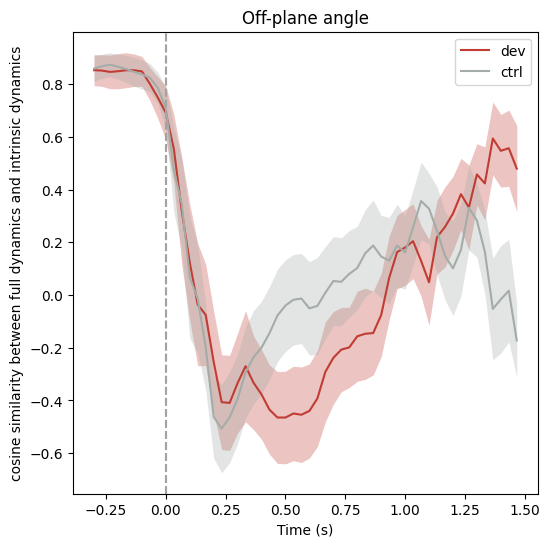

In [4]:
all_session_vector_full_dict= {}
cosine_all_session = {}
max_lag = 5
for key in ['dev', 'ctrl']:
    all_session_vector_full_dict[key] = []
    for session in range(12):
        curr_lag = params_dict[session]['J']
        start = max_lag - curr_lag
        curr_vector_full = np.array(vector_full_record_all[session][key])[start:]
        all_session_vector_full_dict[key].append(curr_vector_full)
        #print(f'{key}', np.array(vector_full_record_all[session][key])[start:].shape)
    colors = {'ctrl': '#a4aca7', 'dev': '#C13C33'}
# baseline from -1 to -0.5 s (per session), then aggregate
x = time_sec[1+max_lag:]  # time axis for arr
# mean sem across session
fig, ax = plt.subplots(figsize=(6, 6))
for key in all_session_vector_full_dict.keys():
    arr = np.array(all_session_vector_full_dict[key])  # (n_sessions, T)

    # per-session baseline
    #baseline = np.mean(arr[:, baseline_mask], axis=1, keepdims=True)
    arr_bs = arr 

    current_mean_array = np.mean(arr_bs, axis=0)
    current_std_array = np.std(arr_bs, axis=0) / np.sqrt(arr_bs.shape[0])

    plt.plot(x, current_mean_array, color=colors[key], linewidth=1.5, label=f'{key}')
    plt.axvline(x=0, color=[0.64, 0.64,0.64], linestyle='--', linewidth=1.5)  
    ax.fill_between(
        x,
        current_mean_array - current_std_array,
        current_mean_array + current_std_array,
        color=colors[key],
        alpha=0.3,
        linewidth=0
    )
plt.xlabel("Time (s)")
plt.ylabel("cosine similarity between full dynamics and intrinsic dynamics")
plt.title("Off-plane angle")
plt.legend()
#plt.savefig(f'direction_overhead_dynamics_sum.pdf')
plt.show()

## Orthogonal angle difference

In [ ]:
params_dict = {
    0: {'L': 0, 'lambda_z': 0.01, 'J': 3,     'lambda_x': 0.1},
    1: {'L': 0, 'lambda_z': 0.05, 'J': 5,     'lambda_x': 1.0},
    2: {'L': 0, 'lambda_z': 0.05, 'J': 4,     'lambda_x': 1.0},
    3: {'L': 0, 'lambda_z': 0.1,  'J': 3,   'lambda_x': 0.5},
    4: {'L': 0, 'lambda_z': 0.1,  'J': 3,     'lambda_x': 0.5},
    5: {'L': 0, 'lambda_z': 0.05, 'J': 4,     'lambda_x': 1},
    6: {'L': 0, 'lambda_z': 0.05, 'J': 3,     'lambda_x': 1},
    7: {'L': 0, 'lambda_z': 0.01, 'J': 3,     'lambda_x': 5},
    8: {'L': 0, 'lambda_z': 0.01, 'J': 3,   'lambda_x': 0.5},
    9: {'L': 0, 'lambda_z': 0.01, 'J': 2,   'lambda_x': 1},
    10:{'L': 0, 'lambda_z': 0.1,  'J': 0,     'lambda_x': 5},
    11:{'L': 1, 'lambda_z': 0.05, 'J': 3,     'lambda_x': 5},
}
mean_cosine_dict_record = []
for session_num in range(12):
    with open(f'/home/sp645/isilon/All_Staff/sp645/data/Yi_deconvoled_calcium/session{session_num}.pkl', "rb") as f:   # "rb" = read, binary
        obj = pickle.load(f)
    print(type(obj))
    print(obj.keys())
    behavior = obj['behavior']
    train_data = obj['train']
    test_data = obj['test']

    print(behavior.shape, train_data.shape)

    Y = behavior[:,:, :2]
    velocity = Y[:, 1:, :] - Y[:, :-1, :]
    U = 1-behavior[:,:, 2]
    X_flatten = train_data.reshape((-1, train_data.shape[-1]))
    #factors_normalized = (X_flatten - X_flatten.min()) / (X_flatten.max() - X_flatten.min())
    #print(Y.shape, U.shape, X_flatten.shape, velocity.shape)

    median = np.median(X_flatten, axis = 1, keepdims=True)
    mad = np.median(np.abs(X_flatten - median), axis = 1, keepdims=True)

    thresh = median + 3*mad
    X_threshold = np.where(X_flatten > thresh, X_flatten, 0.0)
    smoothed_X = gaussian_filter1d(X_threshold, sigma = 1.5, axis = 0)

    velocity = np.concatenate([velocity, np.zeros((train_data.shape[0], 1 ,2))],axis = 1)
    Z = np.concatenate([Y, velocity],axis = -1)
    U = U
    X = smoothed_X.reshape(train_data.shape)
    print(Z.shape, U.shape, X.shape)


    L = params_dict[session_num]['L']
    J = params_dict[session_num]['J']
    results_regression = regression_utils.fit_lag_model_ridge_multitrial(Z, X, U, L = L, J=J, 
                                                                        lam_x=params_dict[session_num]['lambda_x'], 
                                                                        lam_z=params_dict[session_num]['lambda_z'])


    deviation_trial_index = np.unique(np.where(behavior[:, :, -1]==1)[0])
    non_deviation_trial_index = sorted(set(range(behavior.shape[0])) - set(deviation_trial_index))


    mean_control = np.mean(X[non_deviation_trial_index], axis=0)
    mean_dev = np.mean(X[deviation_trial_index], axis=0)

    mean_behavior_control = np.mean(Z[non_deviation_trial_index],axis = 0)
    mean_behavior_dev = np.mean(Z[deviation_trial_index],axis = 0)


    pca = PCA(n_components=3)
    mean_data = np.vstack([mean_control, mean_dev])
    mean_proj = pca.fit_transform(mean_data)

    # fig = plt.figure(figsize=(6, 6))
    # ax = fig.add_subplot(111, projection='3d')

    colors = {'ctrl': '#a4aca7', 'pert': '#C13C33', 'passive': '#006d87'}
    trajectories = {'ctrl': mean_proj[:60], 'dev': mean_proj[60:]}
    # Keep only non-None fields
    trajectories = {k: v for k, v in trajectories.items() if v is not None}

    colors = {'ctrl': '#a4aca7', 'pert': '#C13C33'}
    plane_normal_ctrl, r2_ctrl, reg_ctrl, d_ctrl = regression_utils.fit_trk_plane(trajectories['ctrl'])
    rmse_ctrl = regression_utils.compute_rmse(trajectories['ctrl'], reg_ctrl)
    print(f"Ctrl plane: R² = {r2_ctrl:.3f}")
    print(f"Ctrl Plane RMSE = {rmse_ctrl:.3f}")
    ctrl_proj_on_plane = regression_utils.project_onto_plane(trajectories['ctrl'], plane_normal_ctrl, d_ctrl)
    mean_proj_rotate,Q = regression_utils.rotate_points_to_z(mean_proj, plane_normal_ctrl)

    # plt.figure(figsize=(6, 6))
    frame_indices = np.arange(45, 105)       # original frames
    FS_2P = 30  # Sampling rate in Hz
    time_sec = (frame_indices - 60) / FS_2P 
    dev_proj = mean_proj[60:]
    ctrl_proj = mean_proj[:60]
    # Ctrl
    ctrl_out_of_plane = ctrl_proj @ plane_normal_ctrl + d_ctrl
    # plt.plot(time_sec, ctrl_out_of_plane, color=colors['ctrl'], linewidth=1.5, label='ctrl')

    # # Dev
    # if dev_proj is not None:
    dev_out_of_plane = dev_proj @ plane_normal_ctrl + d_ctrl
    #     plt.plot(time_sec, dev_out_of_plane, color=colors['pert'], linewidth=1.5, label='pert')
    # plt.show()

    if np.abs(np.max(dev_out_of_plane)) - np.abs(np.min(dev_out_of_plane)) < 0:
        print('flip')
        plane_normal_ctrl = -plane_normal_ctrl

    frame_indices = np.arange(45, 105)       # original frames
    FS_2P = 30  # Sampling rate in Hz
    time_sec = (frame_indices - 60) / FS_2P 
    #fig, ax = plt.subplots(figsize=(6, 6))
    K1_lag = results_regression['K1_lag']
    K0_lag = results_regression['K0_lag']
    K01_component_list_all = []
    K1_component_list_all = []
    K0_component_list_all = []
    for trial_num in range(behavior.shape[0]):
        K1_component_list = []
        K01_component_list = []
        K0_component_list = []
        z_real = Z[trial_num]
        u_real = U[trial_num]
        for t in range(1+J, 60):
            K1_component = 0
            K0_component = 0
            for k in range(1+J):
                z_lag = z_real[t - k]       # (z_dim,)
                u_lag = u_real[t-k]
                K1k = K1_lag[k]  
                K0k = K0_lag[k]                  # (x_dim, z_dim)
                K0_component += (z_lag @ K0k.T)
                K1_component += (z_lag @ K1k.T)
            if trial_num in deviation_trial_index:
                K0_component_list.append(K0_component + u_lag*K1_component)
            else:
                K01_component_list.append(K1_component + K0_component)
            K1_component_list.append(K1_component)
        
        K1_component_list_all.append(K1_component_list)
        if trial_num in deviation_trial_index:
            K0_component_list_all.append(K0_component_list)
        else:
            K01_component_list_all.append(K01_component_list)

    #print('perturbed_control vector:', np.array(K0_component_list_all).shape, 'ctrl_control vector:', np.array(K01_component_list_all).shape, np.array(K1_component_list_all).shape)
    pc_K1_components = np.array(K1_component_list_all)@pca.components_.T
    norm_pc_K1_components = pc_K1_components/ np.linalg.norm(pc_K1_components, axis = 2, keepdims=True)
    pc_K0_components = np.array(K0_component_list_all)@pca.components_.T
    norm_pc_K0_components = pc_K0_components/ np.linalg.norm(pc_K0_components, axis = 2, keepdims=True)
    pc_K01_components = np.array(K01_component_list_all)@pca.components_.T
    norm_pc_K01_components = pc_K01_components/ np.linalg.norm(pc_K01_components, axis = 2, keepdims=True)
    #print('normal vector: ', plane_normal_ctrl)
    norm_plane_normal_ctrl = plane_normal_ctrl / np.linalg.norm(plane_normal_ctrl)
    #print(norm_pc_K1_components.shape)
    normK1_multiplication_res = norm_pc_K1_components@norm_plane_normal_ctrl
    normK0_multiplication_res = norm_pc_K0_components@norm_plane_normal_ctrl
    normK01_multiplication_res = norm_pc_K01_components@norm_plane_normal_ctrl

    colors = {'pert': '#C13C33', 'K1_only': "#0e9f43", 'ctrl': '#a4aca7'}
    norm_res = {'pert':normK0_multiplication_res, 'ctrl': normK01_multiplication_res}#'K1_only': normK1_multiplication_res, 
    mean_cosine_dict = {}
    for key in norm_res.keys():
        current_cosine = norm_res[key]
        #degree_from_norm = 90-np.degrees(np.arccos(current_cosine))
        mean_cos = np.nanmean(current_cosine, axis = 0)
        # std_cos = np.nanstd(current_cosine, axis = 0)/np.sqrt(current_cosine.shape[0])
        mean_cosine_dict[key] = mean_cos

    #     x = time_sec[1+J:]

    #     # --- Plot mean ± SEM lines and error bars
    #     plt.plot(x, mean_cos, color=colors[key], linewidth=1.5, label=f'{key}')
    #     plt.axvline(x=0, color='k', linestyle='--', linewidth=1.5)  
    #     ax.errorbar(x, mean_cos, yerr=std_cos,
    #                 fmt='o', color=colors[key], markersize=5,
    #                 markeredgewidth=1.5, capsize=0, elinewidth=1,
    #                 zorder=3)
    # plt.xlabel("Time (s)")
    # plt.ylabel("cosine similarity between task plane normal vector and control")
    # plt.title("Off-plane angle")
    # plt.legend()
    # #plt.savefig(f'paper_figures_all_sessions/control_cosine_similarity/control_cosine_similarity_session{session_num}.pdf')
    # plt.show()
    mean_cosine_dict_record.append(mean_cosine_dict)


<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 57)
(140, 60, 4) (140, 60) (140, 60, 57)
Ctrl plane: R² = 0.945
Ctrl Plane RMSE = 0.810
<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 28)
(140, 60, 4) (140, 60) (140, 60, 28)
Ctrl plane: R² = 0.478
Ctrl Plane RMSE = 1.714
flip
<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 37)
(140, 60, 4) (140, 60) (140, 60, 37)
Ctrl plane: R² = 0.974
Ctrl Plane RMSE = 0.438
<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 76)
(140, 60, 4) (140, 60) (140, 60, 76)
Ctrl plane: R² = 0.916
Ctrl Plane RMSE = 1.385
<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 51)
(140, 60, 4) (140, 60) (140, 60, 51)
Ctrl plane: R² = 0.802
Ctrl Plane RMSE = 0.854
<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 34)
(140, 60, 4) (140, 60) (140, 60, 34)
Ctrl plane: R² = 0.713
Ctrl Plane RMSE =

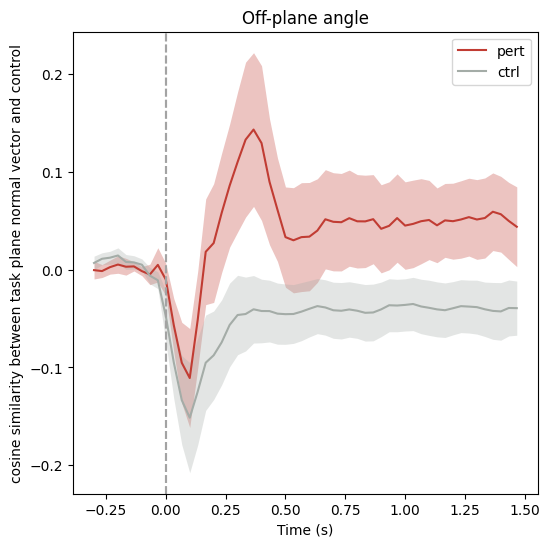

In [8]:
all_session_mean_dict = {}
max_lag = 5
for key in mean_cosine_dict_record[0].keys():
    all_session_mean_dict[key] = []
    for i in range(12):
        curr_lag = params_dict[i]['J']
        start = max_lag - curr_lag
        all_session_mean_dict[key].append(mean_cosine_dict_record[i][key][start:])
        #print(f'{key}', mean_cosine_dict_record[i][key][start:].shape)

# baseline from -1 to -0.5 s (per session), then aggregate
x = time_sec[1+5:]  # time axis for arr
baseline_mask = (x >= -0.5) & (x <= 0)

# mean sem across session
fig, ax = plt.subplots(figsize=(6, 6))
for key in all_session_mean_dict.keys():
    arr = np.array(all_session_mean_dict[key])  # (n_sessions, T)

    # per-session baseline
    baseline = np.mean(arr[:, baseline_mask], axis=1, keepdims=True)
    arr_bs = arr - baseline

    current_mean_array = np.mean(arr_bs, axis=0)
    current_std_array = np.std(arr_bs, axis=0) / np.sqrt(arr_bs.shape[0])

    # current_mean_array = np.mean(np.array(all_session_mean_dict[key]), axis = 0)
    # current_std_array = np.std(np.array(all_session_mean_dict[key]), axis = 0)/np.sqrt(12)

    plt.plot(x, current_mean_array, color=colors[key], linewidth=1.5, label=f'{key}')
    plt.axvline(x=0, color=[0.64, 0.64,0.64], linestyle='--', linewidth=1.5)  
    ax.fill_between(
        x,
        current_mean_array - current_std_array,
        current_mean_array + current_std_array,
        color=colors[key],
        alpha=0.3,
        linewidth=0
    )
plt.xlabel("Time (s)")
plt.ylabel("cosine similarity between task plane normal vector and control")
plt.title("Off-plane angle")
plt.legend()
#plt.savefig(f'direction_kinematics_drive_sum.pdf')
plt.show()